# Setting

## Load Library

In [1]:
import pandas as pd
import numpy as np

from scipy import stats 
from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

import random
import os

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # F1-Score
from sklearn.metrics import confusion_matrix

## Fix Random Seed

In [4]:
def my_seed_everywhere(seed):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os

In [5]:
# seed를 고정시킴으로써 동일한 결과값 출력
SEED = 42
my_seed_everywhere(SEED)

# Load Data Set

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
# 자신의 경로에 맞게 수정
path_file = '/content/drive/MyDrive/UNIST/AICP/data/dynmom_dat.csv'

df = pd.read_csv(path_file)

# Preprocessing

## Set Index

In [57]:
# 'DATE'를 칼럼 대신 인덱스로 사용
df.index = df['DATE']
df = df.drop(columns='DATE')

## Drop Rows & Cols

In [58]:
# 결측치 제거 및 모델 학습에 불필요한 칼럼 제거
drop_null_df = df.dropna()
drop_cols_df = drop_null_df.drop(columns=['winner', 'loser', 'form_date'])

## Generate Target

### Normal

In [59]:
# 'wml'의 양수 여부를 기준으로 'pos_wml' 라벨 생성
def normal_wml(df):

  cond_wml = (df['wml']>=0)
  df.loc[cond_wml, 'pos_wml'] = 1
  df.loc[~cond_wml, 'pos_wml'] = 0

  df.drop(columns=['wml'], inplace=True)

  POS_WML = df['pos_wml'].value_counts()
  print(f' Ratio : {POS_WML[0]/POS_WML[1]}')
  print(POS_WML)

  return df

In [60]:
dynmom = normal_wml(drop_cols_df)

 Ratio : 0.5634379263301501
1.0    733
0.0    413
Name: pos_wml, dtype: int64


# Modeling

## Rolling Windows

In [61]:
def Roling_Windows(data, window_size, method, model, model_name, plot=True, plot_feature=True):

  # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
  result_dict = {
    'TRAIN_START_DATE':[],
    'TRAIN_END_DATE':[],
    'TEST_DATE':[],
    'Actual_POS_WML':[],
    f'{model_name}_PRED_POS_WML':[]
  }

  df_feature = pd.DataFrame()

  i = 0

  # 모델 학습이 종료되는 지점 설정
  end = data.shape[0] - window_size - 1

  while True:

    # 모델 학습 중지
    if i == end:
      print('Prediction using machine learning has ended.')
      break
    
    # Rolling Fixed Window
    if method == 'Fixed':
      MODEL = model
      train = data.iloc[0+i:window_size+1+i]

    # Rolling Expanding Window
    elif method == 'Expanding':
      MODEL = model
      train = data.iloc[0:window_size+1+i]
    
    # 'method' 잘못입력한 경우
    else:
      print("Make sure to set the method to either 'Fixed' or 'Expanding'.")
      break
    
    # 테스트 데이터 설정
    test = data.iloc[[window_size+1+i]]

    # Features와 Target 구분
    X_train = train.drop(columns=['pos_wml'])
    y_train = train['pos_wml']

    X_test = test.drop(columns=['pos_wml'])
    y_test = test['pos_wml'] 

    # 모델 학습 및 추론
    MODEL.fit(X_train, y_train)
    pred_test = MODEL.predict(X_test)

    # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
    result_dict['TRAIN_START_DATE'].append(train.index[0])
    result_dict['TRAIN_END_DATE'].append(train.index[-1])
    result_dict['TEST_DATE'].append(test.index[0])

    result_dict['Actual_POS_WML'].append(list(y_test)[0])
    result_dict[f'{model_name}_PRED_POS_WML'].append(pred_test[0])

    # 트리 기반 모델 (사이킷런)의 Feature Importance 정보 수집
    feature_importances = MODEL.feature_importances_
    df_ft_importance = pd.DataFrame(feature_importances, index = X_train.columns).T
    df_ft_importance.index = y_test.index
    df_feature = pd.concat([df_feature, df_ft_importance])

    i += 1

  result = pd.DataFrame(result_dict)
  result.index = df_feature.index

  result = pd.concat([result, df_feature], axis=1)
  result = result.set_index('TEST_DATE')
  
  # 모델 성능 시각화
  if plot == True:
    plot_result(result, method, model_name)
  
  # 모델의 변수 중요도 시각화
  if plot_feature == True:
    plot_feature_importances(result)
    print()

  # 학습 및 테스트 데이터 정보, 실제값과 예측값 정보, 변수 중요도 정보
  return result

In [62]:
# 모델 성능 시각화
def plot_result(data, method, model_name):
  print('\nPerformance results of the model\n')

  # Confusion Matrix & etc
  print(classification_report(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML']))

  # Accuracy, Precision, Recall, F1 Score
  accuracy = accuracy_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  precision = precision_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  recall = recall_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  F1_score = f1_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])

  print(f'\naccuracy : {accuracy}')
  print(f'\nprecision : {precision}')
  print(f'\nrecall : {recall}')
  print(f'\nF1-Score : {F1_score}\n')
  
  # Visualization Confusion Matrix
  confusion = confusion_matrix(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  sns.heatmap(confusion, annot=True, fmt='g')
  plt.title(f'Performance results ({method}) of the {model_name} model')
  
  plt.show()

In [63]:
# Feature Importance 시각화
def plot_feature_importances(data):

  data = data[['mvol_cum6', 'mvol_t_1', 'mvol_t_2', 'mvol_t_3',
       'mvol_t_4', 'mvol_t_5', 'mvol_t_6', 'cum_loser', 'cum_winner',
       'cum_loser_t_2_4', 'cum_winner_t_2_4', 'cum_loser_t_5_8',
       'cum_winner_t_5_8', 'cum_loser_t_9_12', 'cum_winner_t_9_12']]

  print('\nFeature Importance of the model\n')

  # 날짜 별 Feature Importance 변화 추이
  plt.figure(figsize=(15, 5))
  for col in data.columns:

    sns.lineplot(data=data,
                x=data.index,
                y=col,
                label=col,
                alpha=0.3)
    
    plt.title('Feature importances using MDI')
    plt.xlabel('DATE')
    plt.ylabel('Mean decrease in impurity')
    plt.xticks([data.index[i] for i in range(0,len(data.index), 12)])
    plt.tick_params(axis='x',
                      direction='out',
                      labelrotation=45,
                      length=1,
                      pad=10,
                      labelsize=5,
                      width=0.1)
  plt.show()

  # 각 변수 별 Feature Importance 통계값
  MEAN = display_feature_importance(data, method='mean')
  MAX = display_feature_importance(data, method='max')
  MIN = display_feature_importance(data, method='min')

  plt.figure(figsize=(15, 5))
  sns.barplot(data=MEAN,
              y=MEAN.index,
              x='mean_Feature_Importance')

  plt.show()
  print()

  FEATURE_IMPORTANCE = pd.concat([MEAN, MAX, MIN], axis=1)
  display(FEATURE_IMPORTANCE)

In [64]:
# 각 변수 별 Feature Importance 통계값
def display_feature_importance(data, method):

    data = data[['mvol_cum6', 'mvol_t_1', 'mvol_t_2', 'mvol_t_3',
       'mvol_t_4', 'mvol_t_5', 'mvol_t_6', 'cum_loser', 'cum_winner',
       'cum_loser_t_2_4', 'cum_winner_t_2_4', 'cum_loser_t_5_8',
       'cum_winner_t_5_8', 'cum_loser_t_9_12', 'cum_winner_t_9_12']]
       
    feature_dict = {}
    for col in data.columns:
      if method=='mean':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].mean())

      if method=='max':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].max())
      
      if method=='min':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].min())
    
    feature_df = pd.DataFrame(feature_dict).T
    feature_df.columns = [method+'_'+'Feature_Importance']
    feature_df=feature_df.sort_values(by=method+'_'+'Feature_Importance', ascending=False)

    return feature_df

In [75]:
def slice_data(data, num, method, model_name):

  division = int(data.shape[0]/num)
  
  for i in range(num):

    if i == num-1:
      sliced_data = data.iloc[i*division:]

    else:
      sliced_data = data.iloc[i*division:(i+1)*division]

    start = sliced_data.index[0]
    end = sliced_data.index[-1]

    print()
    print('*'*50)
    print(f'\nDATE : {start} ~ {end}\n')
    print('*'*50)
    print()
    
    plot_result(sliced_data, method, model_name)
    plot_feature_importances(sliced_data)

## Model

In [65]:
# 랜덤 포레스트 모델 사용 (트리 기반)
model = RandomForestClassifier(random_state=SEED)

## Inference

### Rolling Fixed Windows

Prediction using machine learning has ended.

Performance results of the model

              precision    recall  f1-score   support

         0.0       0.42      0.23      0.29       315
         1.0       0.67      0.83      0.74       590

    accuracy                           0.62       905
   macro avg       0.54      0.53      0.52       905
weighted avg       0.58      0.62      0.59       905


accuracy : 0.6220994475138122

precision : 0.6684782608695652

recall : 0.8338983050847457

F1-Score : 0.7420814479638009



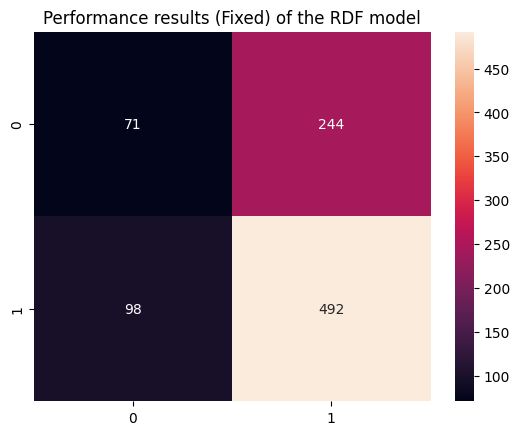


Feature Importance of the model



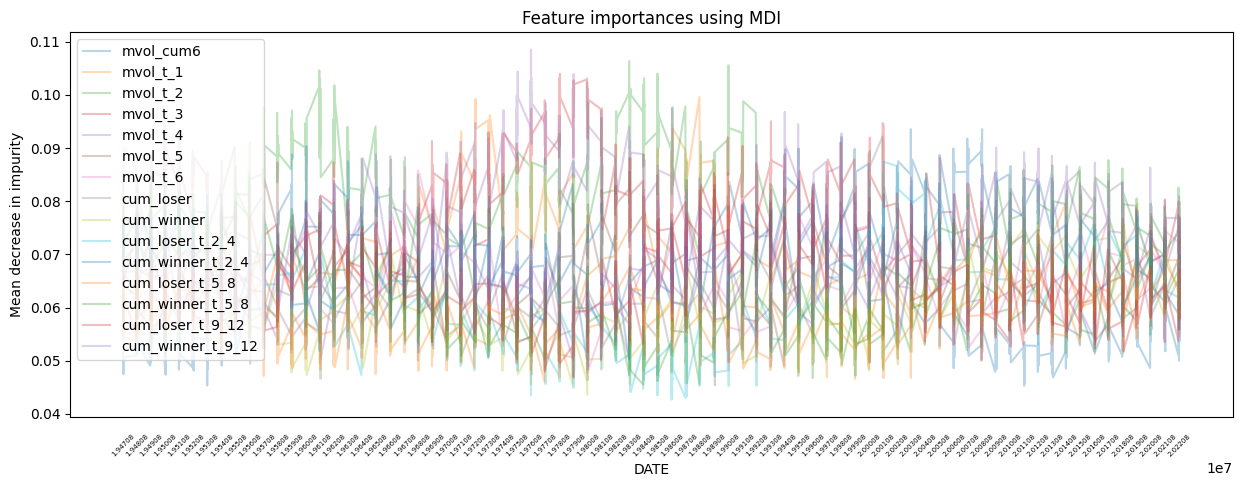

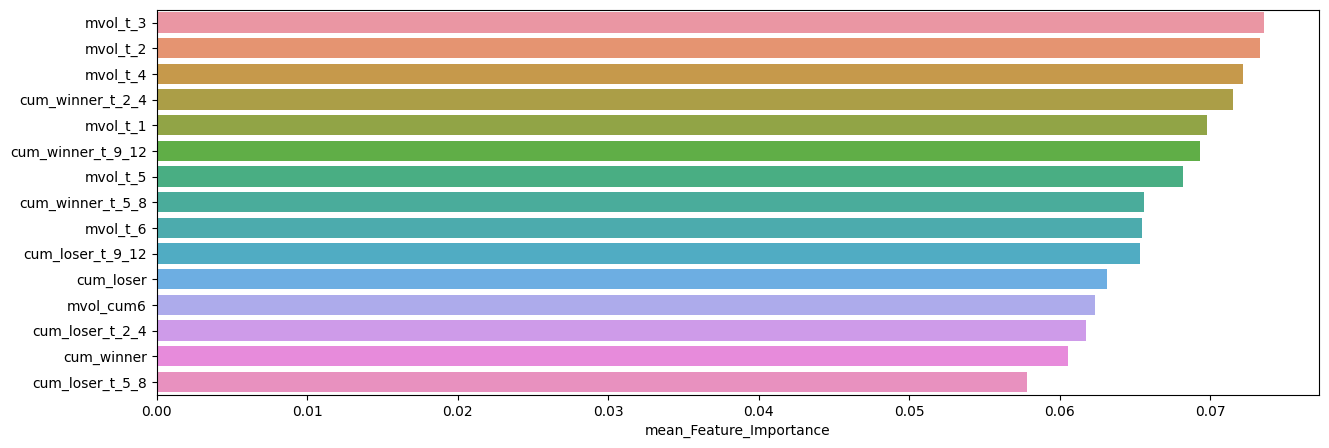

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
mvol_t_3,0.073565,0.103966,0.052317
mvol_t_2,0.073300,0.106363,0.048265
mvol_t_4,0.072194,0.108486,0.050457
cum_winner_t_2_4,0.071518,0.093544,0.050217
mvol_t_1,0.069828,0.099580,0.053613
cum_winner_t_9_12,0.069311,0.090102,0.048916
mvol_t_5,0.068192,0.094496,0.045354
cum_winner_t_5_8,0.065609,0.087735,0.045517
mvol_t_6,0.065470,0.090256,0.046702
cum_loser_t_9_12,0.065320,0.094716,0.046988


In [66]:
Fixed_RDF_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=model, # 사용할 모델
                                  model_name='RDF', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470829 ~ 19660531

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.24      0.30        75
         1.0       0.68      0.81      0.74       151

    accuracy                           0.62       226
   macro avg       0.53      0.52      0.52       226
weighted avg       0.58      0.62      0.59       226


accuracy : 0.6194690265486725

precision : 0.6815642458100558

recall : 0.8079470198675497

F1-Score : 0.7393939393939395



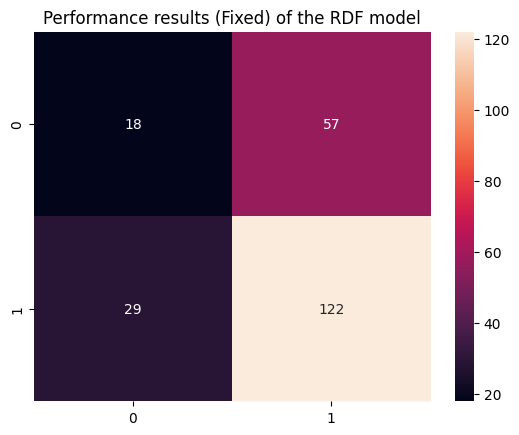


Feature Importance of the model



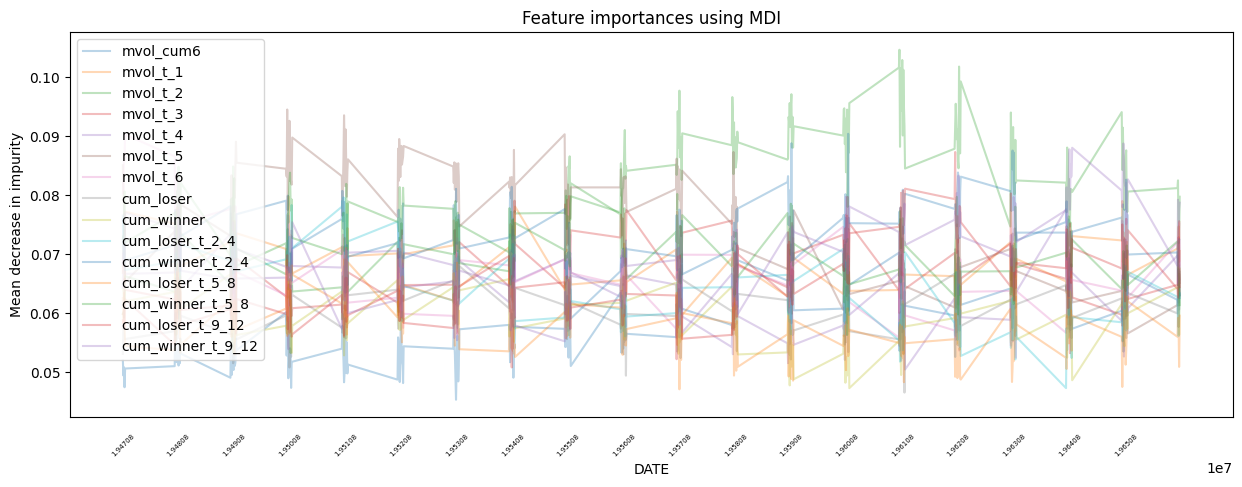

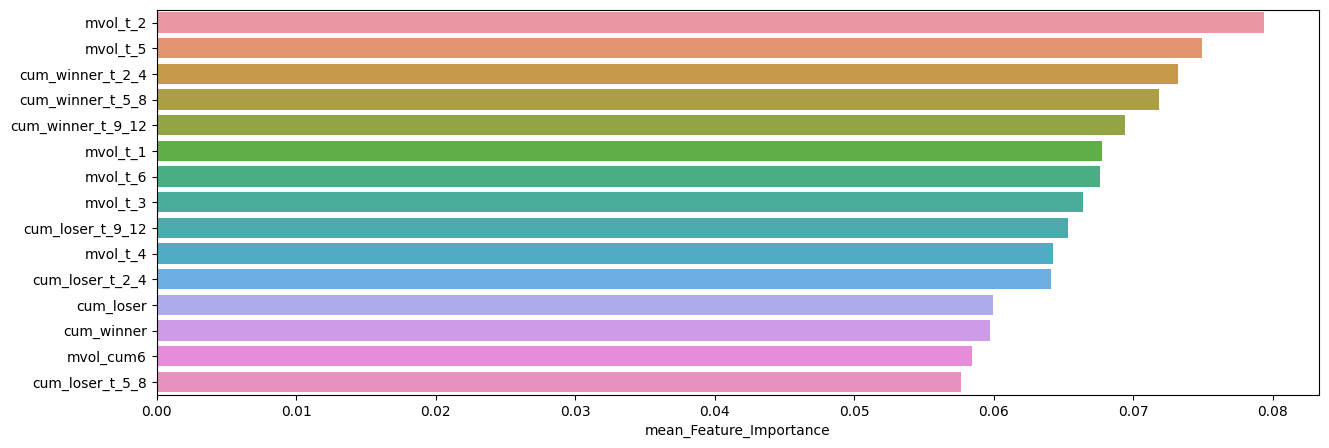

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
mvol_t_2,0.079351,0.104617,0.053257
mvol_t_5,0.074907,0.094496,0.056584
cum_winner_t_2_4,0.073233,0.090381,0.059099
cum_winner_t_5_8,0.071864,0.085401,0.056329
cum_winner_t_9_12,0.069396,0.088743,0.055239
mvol_t_1,0.067748,0.079820,0.055537
mvol_t_6,0.067651,0.090256,0.052462
mvol_t_3,0.066420,0.079838,0.053151
cum_loser_t_9_12,0.065322,0.087296,0.050822
mvol_t_4,0.064232,0.079270,0.050457



**************************************************

DATE : 19660630 ~ 19850329

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.44      0.22      0.29        74
         1.0       0.69      0.87      0.77       152

    accuracy                           0.65       226
   macro avg       0.57      0.54      0.53       226
weighted avg       0.61      0.65      0.61       226


accuracy : 0.6548672566371682

precision : 0.6947368421052632

recall : 0.868421052631579

F1-Score : 0.7719298245614035



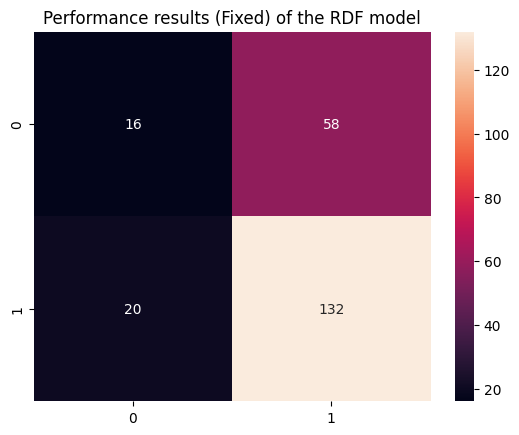


Feature Importance of the model



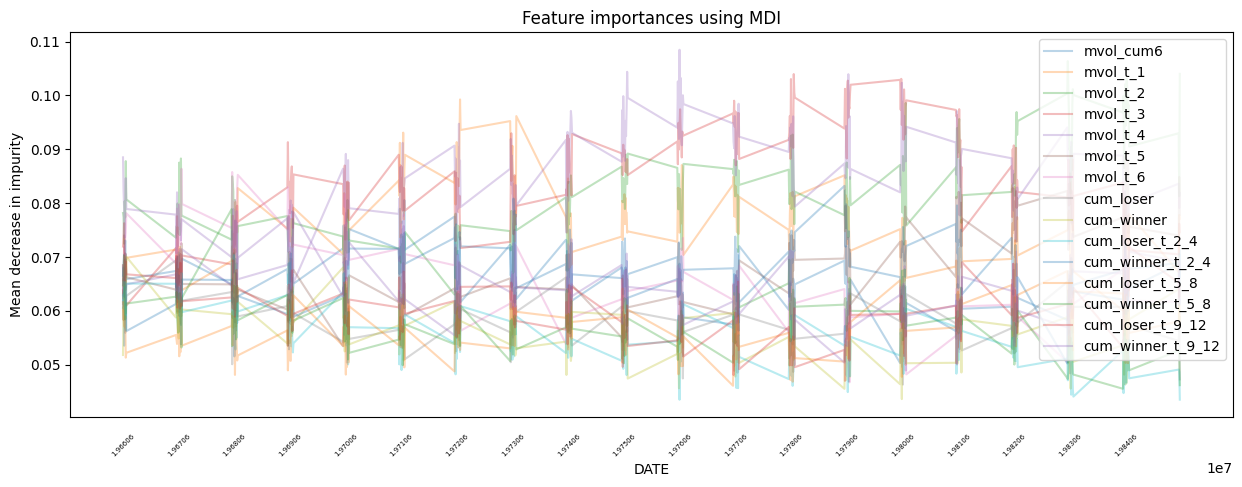

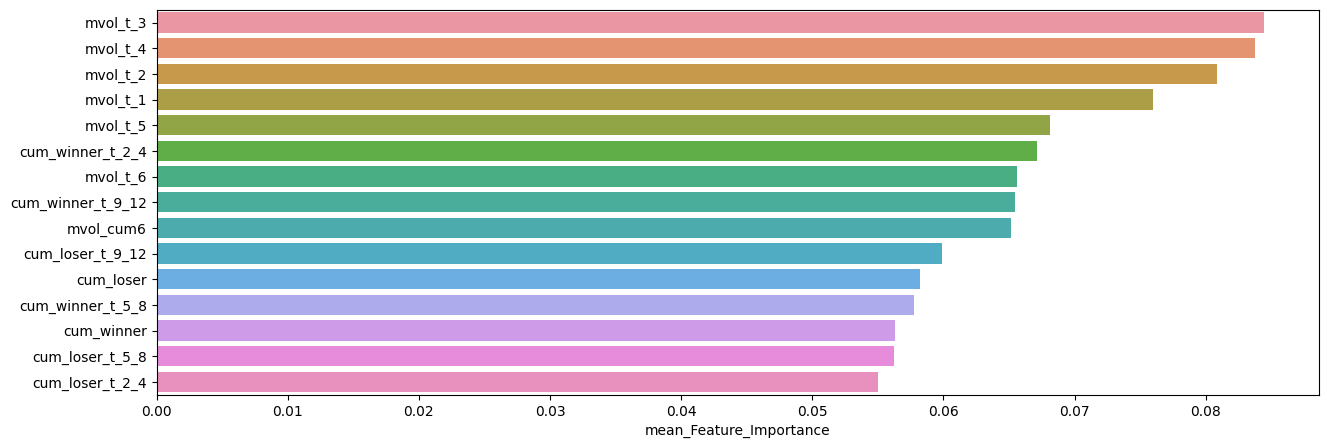

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
mvol_t_3,0.084423,0.103966,0.060736
mvol_t_4,0.083760,0.108486,0.062241
mvol_t_2,0.080882,0.106363,0.060479
mvol_t_1,0.075998,0.099255,0.057996
mvol_t_5,0.068113,0.088739,0.053414
cum_winner_t_2_4,0.067111,0.083203,0.050217
mvol_t_6,0.065630,0.086376,0.046702
cum_winner_t_9_12,0.065448,0.088501,0.048916
mvol_cum6,0.065174,0.080579,0.050280
cum_loser_t_9_12,0.059890,0.076264,0.046988



**************************************************

DATE : 19850430 ~ 20040130

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.20      0.26        70
         1.0       0.70      0.85      0.77       156

    accuracy                           0.65       226
   macro avg       0.54      0.53      0.52       226
weighted avg       0.60      0.65      0.61       226


accuracy : 0.6504424778761062

precision : 0.7037037037037037

recall : 0.8525641025641025

F1-Score : 0.7710144927536231



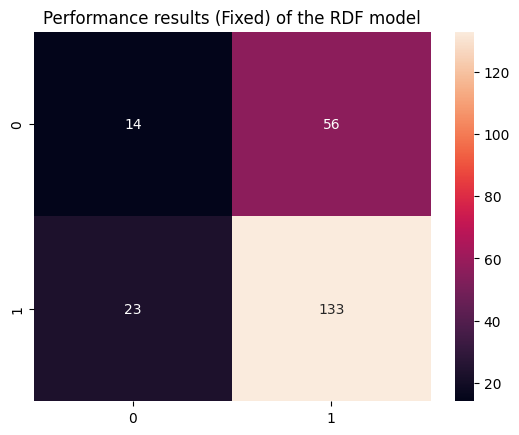


Feature Importance of the model



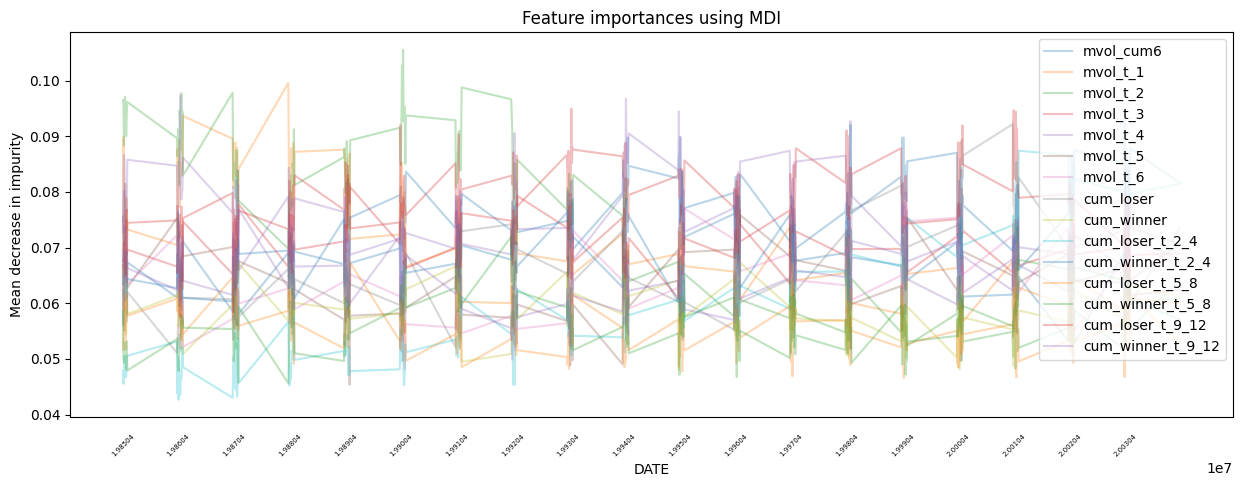

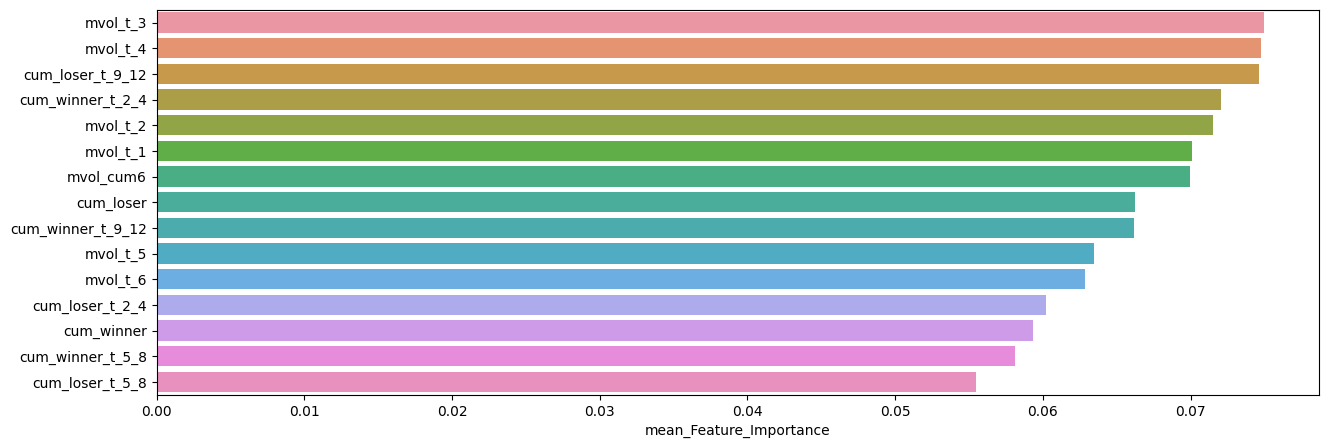

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
mvol_t_3,0.074958,0.095002,0.058685
mvol_t_4,0.074770,0.097380,0.054241
cum_loser_t_9_12,0.074648,0.094716,0.057504
cum_winner_t_2_4,0.072096,0.093528,0.056083
mvol_t_2,0.071528,0.105540,0.048265
mvol_t_1,0.070114,0.099580,0.053613
mvol_cum6,0.069937,0.089869,0.052515
cum_loser,0.066210,0.092176,0.051116
cum_winner_t_9_12,0.066207,0.084490,0.052405
mvol_t_5,0.063472,0.081507,0.045354



**************************************************

DATE : 20040227 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.47      0.24      0.32        96
         1.0       0.59      0.80      0.68       131

    accuracy                           0.56       227
   macro avg       0.53      0.52      0.50       227
weighted avg       0.54      0.56      0.53       227


accuracy : 0.5638766519823789

precision : 0.5898876404494382

recall : 0.8015267175572519

F1-Score : 0.6796116504854368



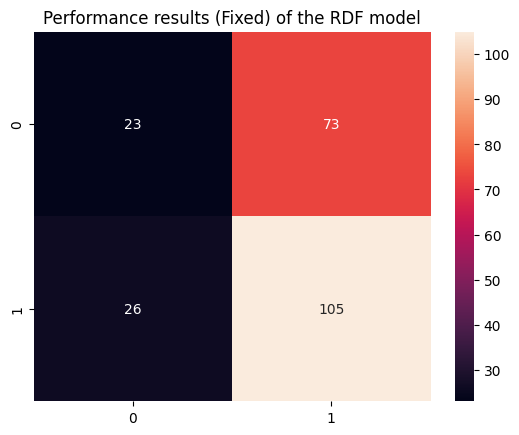


Feature Importance of the model



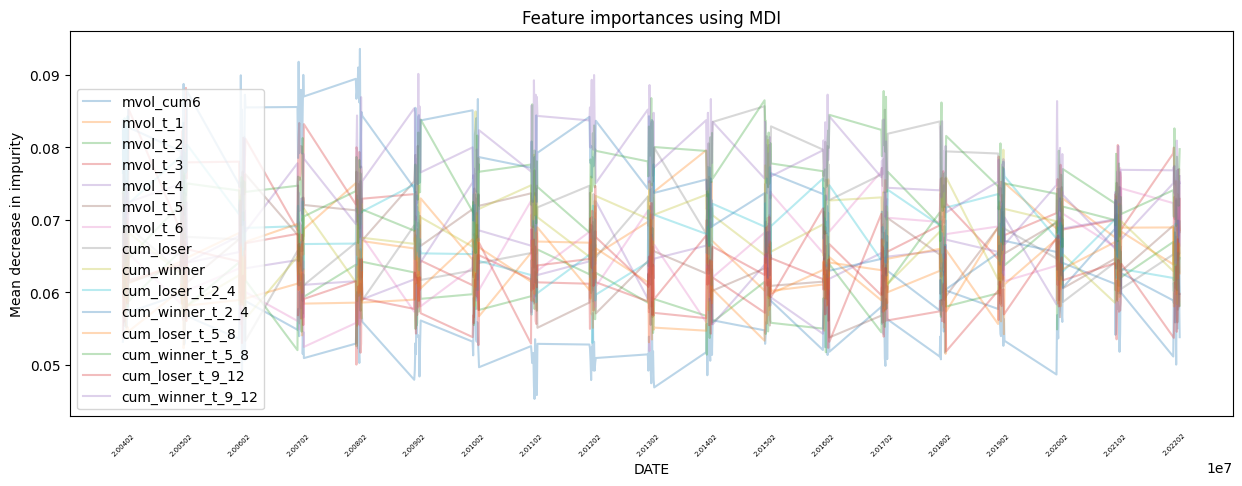

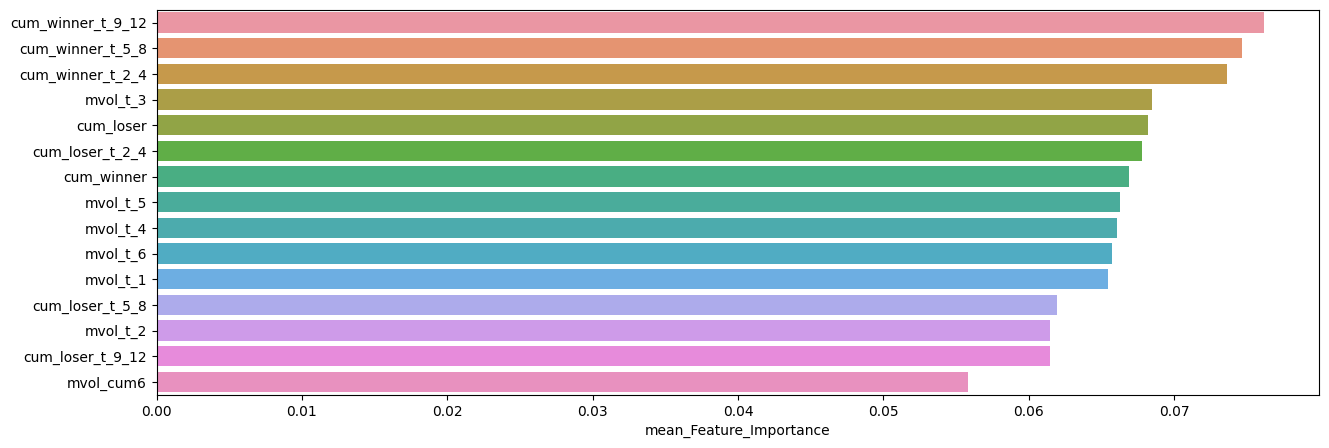

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
cum_winner_t_9_12,0.076164,0.090102,0.062746
cum_winner_t_5_8,0.074638,0.087735,0.059318
cum_winner_t_2_4,0.073624,0.093544,0.054562
mvol_t_3,0.068483,0.088165,0.052317
cum_loser,0.068181,0.085639,0.053296
cum_loser_t_2_4,0.067793,0.084265,0.053005
cum_winner,0.066911,0.084922,0.056330
mvol_t_5,0.066282,0.080167,0.053752
mvol_t_4,0.066042,0.081387,0.054261
mvol_t_6,0.065718,0.077138,0.051855


In [76]:
slice_data(Fixed_RDF_Result, 4, 'Fixed', 'RDF')

### Rolling Expanding Windows

Prediction using machine learning has ended.

Performance results of the model

              precision    recall  f1-score   support

         0.0       0.40      0.17      0.24       315
         1.0       0.66      0.86      0.75       590

    accuracy                           0.62       905
   macro avg       0.53      0.52      0.50       905
weighted avg       0.57      0.62      0.57       905


accuracy : 0.6232044198895028

precision : 0.6618985695708712

recall : 0.8627118644067797

F1-Score : 0.7490802060338485



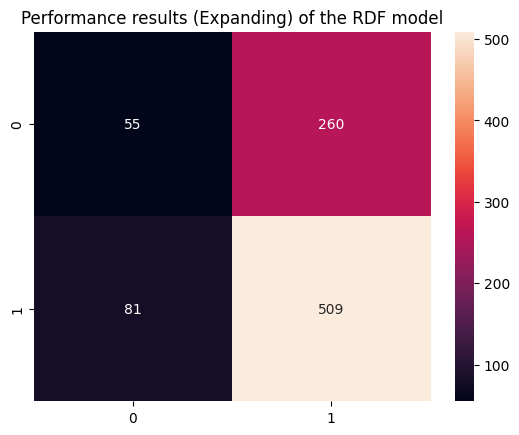


Feature Importance of the model



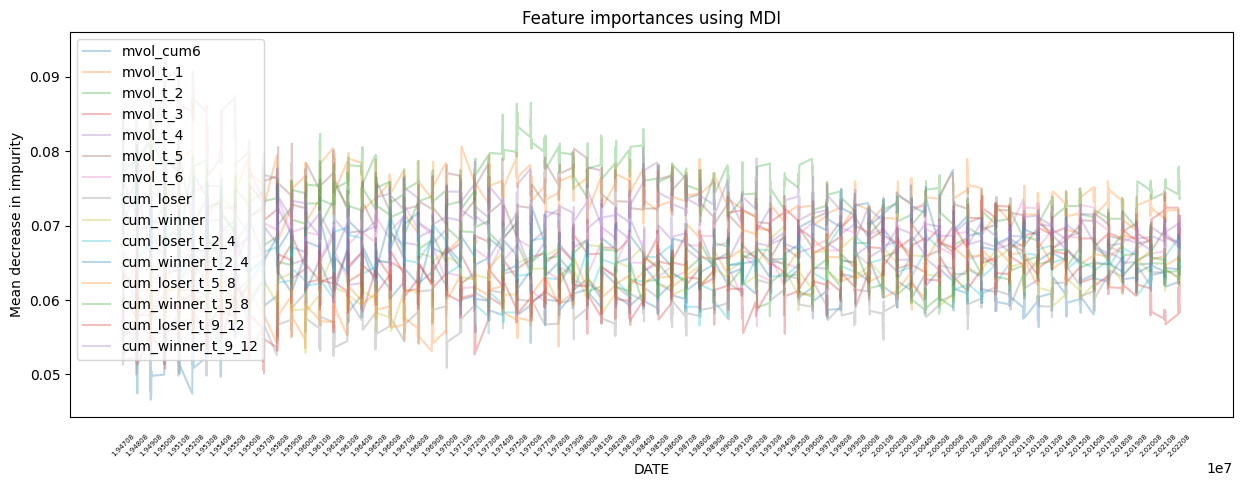

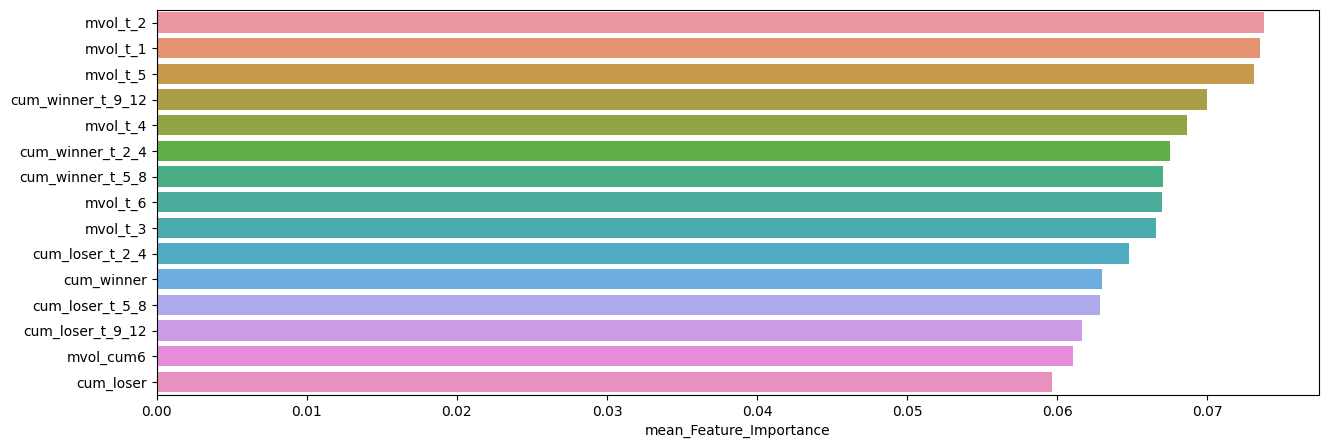

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
mvol_t_2,0.073750,0.086492,0.057529
mvol_t_1,0.073512,0.087151,0.066192
mvol_t_5,0.073099,0.093633,0.063911
cum_winner_t_9_12,0.069954,0.080474,0.059452
mvol_t_4,0.068607,0.081058,0.060884
cum_winner_t_2_4,0.067511,0.080849,0.058152
cum_winner_t_5_8,0.067069,0.085015,0.057816
mvol_t_6,0.066983,0.084579,0.056476
mvol_t_3,0.066570,0.075707,0.052820
cum_loser_t_2_4,0.064774,0.083911,0.055507


In [18]:
Expanding_RDF_Result = Roling_Windows(data=dynmom,
                                  window_size=240,
                                  method='Expanding',
                                  model=model,
                                  model_name='RDF',
                                  plot=True)


**************************************************

DATE : 19470829 ~ 19660531

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.41      0.25      0.31        75
         1.0       0.69      0.82      0.75       151

    accuracy                           0.63       226
   macro avg       0.55      0.54      0.53       226
weighted avg       0.60      0.63      0.60       226


accuracy : 0.6327433628318584

precision : 0.6888888888888889

recall : 0.8211920529801324

F1-Score : 0.7492447129909365



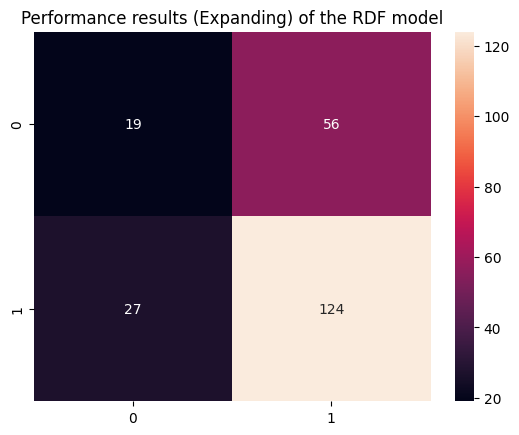


Feature Importance of the model



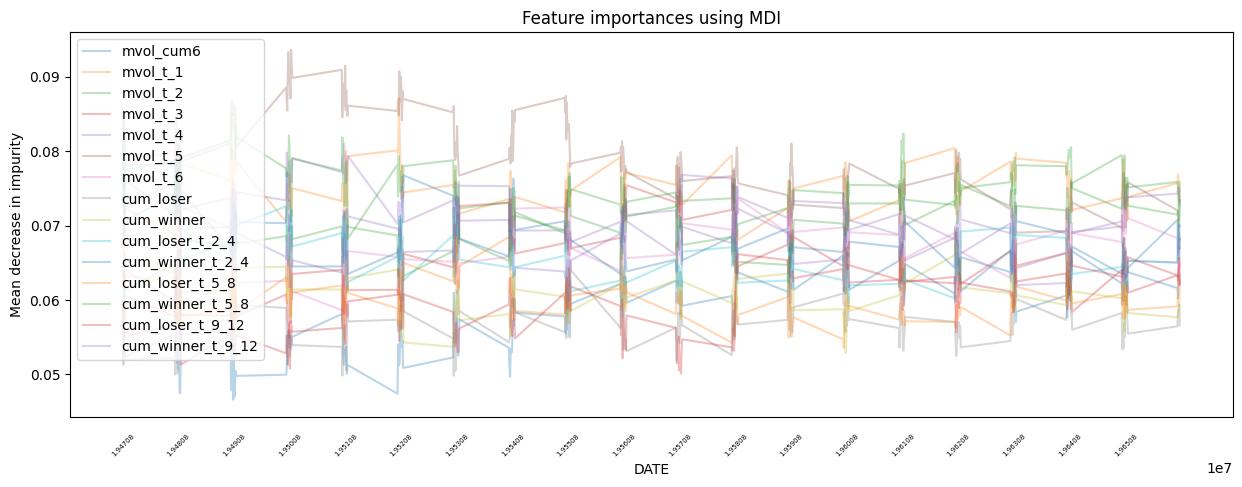

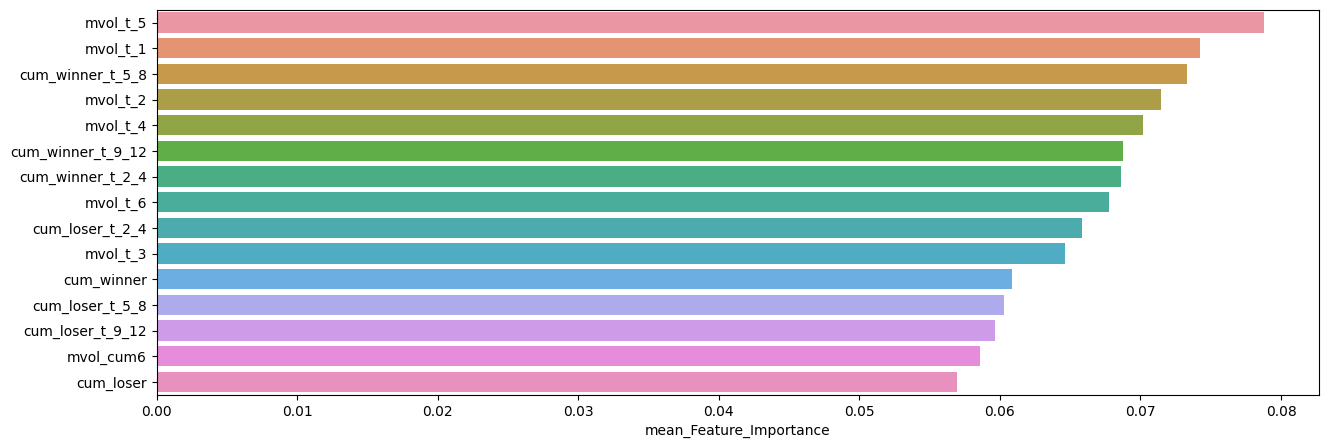

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
mvol_t_5,0.078772,0.093633,0.066973
mvol_t_1,0.074262,0.087151,0.066192
cum_winner_t_5_8,0.073319,0.085015,0.062337
mvol_t_2,0.071468,0.082356,0.057529
mvol_t_4,0.070200,0.081058,0.060884
cum_winner_t_9_12,0.068786,0.075528,0.059452
cum_winner_t_2_4,0.068625,0.080849,0.060715
mvol_t_6,0.067768,0.084579,0.058637
cum_loser_t_2_4,0.065822,0.083911,0.057931
mvol_t_3,0.064609,0.075707,0.052820



**************************************************

DATE : 19660630 ~ 19850329

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.15      0.21        74
         1.0       0.68      0.87      0.76       152

    accuracy                           0.63       226
   macro avg       0.52      0.51      0.49       226
weighted avg       0.57      0.63      0.58       226


accuracy : 0.6327433628318584

precision : 0.676923076923077

recall : 0.868421052631579

F1-Score : 0.760806916426513



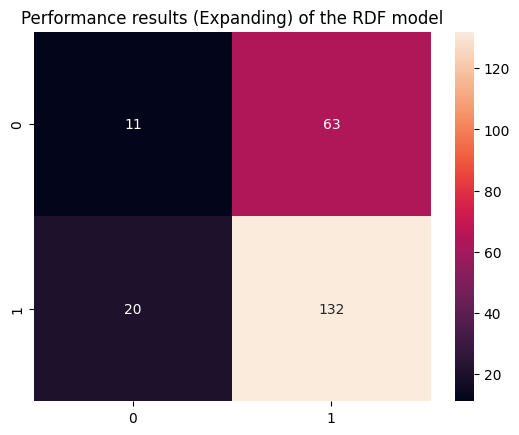


Feature Importance of the model



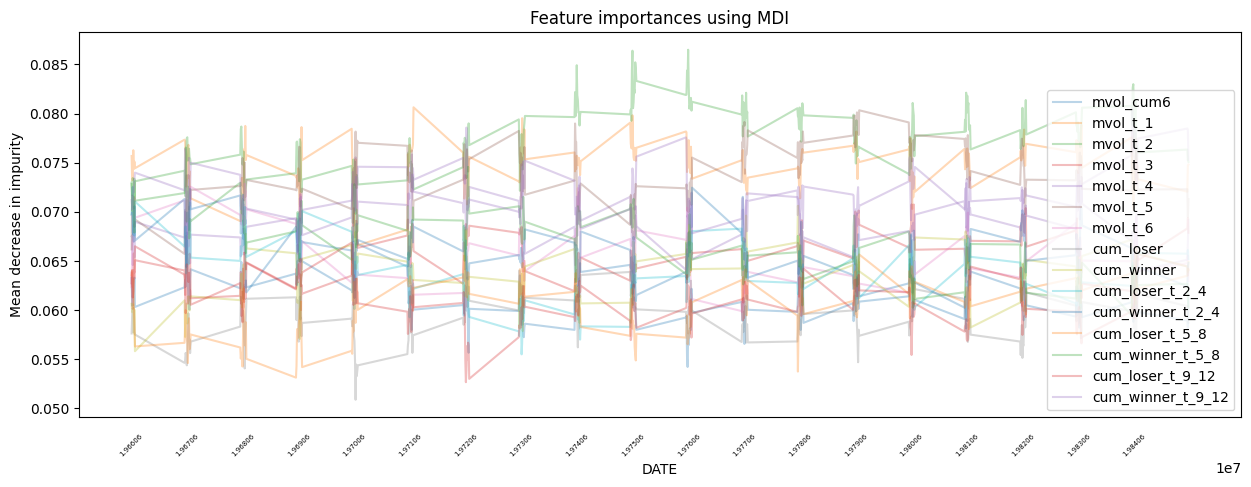

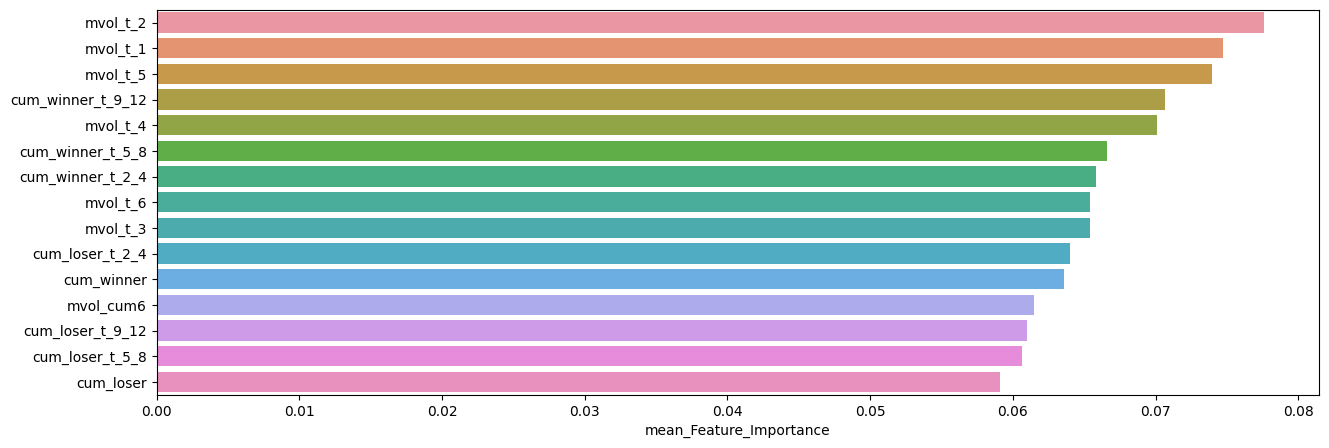

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
mvol_t_2,0.077581,0.086492,0.068885
mvol_t_1,0.074697,0.080637,0.066600
mvol_t_5,0.073981,0.080334,0.065726
cum_winner_t_9_12,0.070672,0.080474,0.063750
mvol_t_4,0.070078,0.078577,0.063810
cum_winner_t_5_8,0.066596,0.076537,0.059486
cum_winner_t_2_4,0.065821,0.072459,0.058152
mvol_t_6,0.065423,0.072869,0.059423
mvol_t_3,0.065412,0.070762,0.059142
cum_loser_t_2_4,0.063975,0.072517,0.055507



**************************************************

DATE : 19850430 ~ 20040130

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.11      0.17        70
         1.0       0.69      0.90      0.78       156

    accuracy                           0.65       226
   macro avg       0.51      0.51      0.48       226
weighted avg       0.58      0.65      0.59       226


accuracy : 0.6548672566371682

precision : 0.693069306930693

recall : 0.8974358974358975

F1-Score : 0.7821229050279329



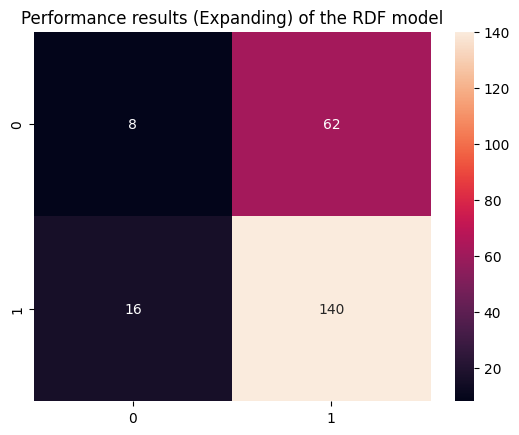


Feature Importance of the model



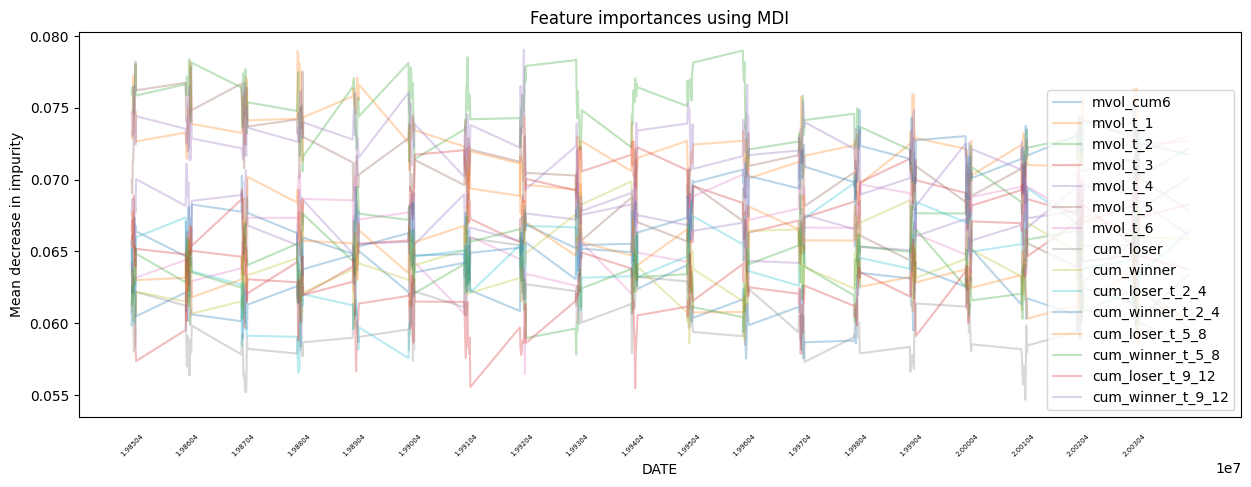

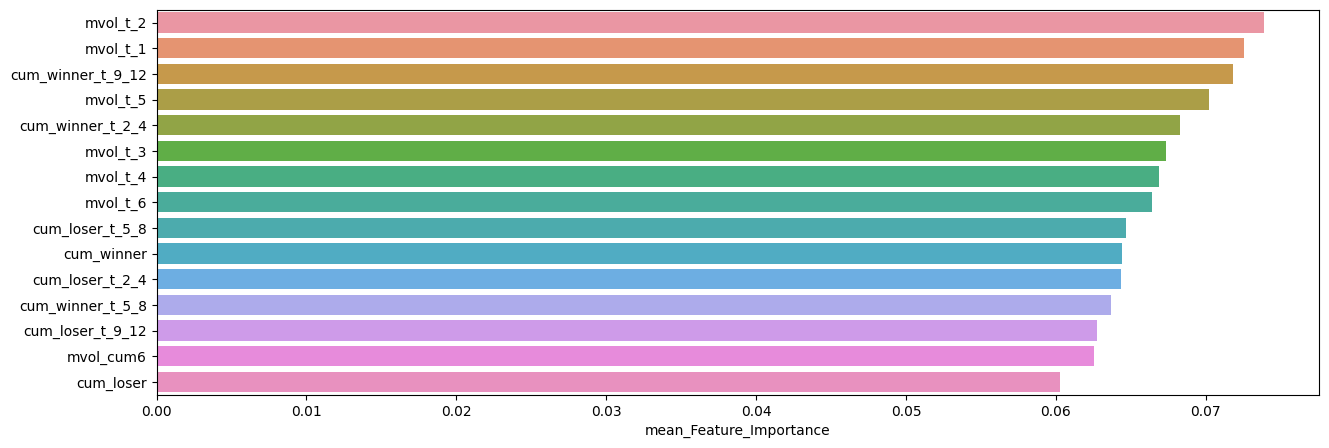

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
mvol_t_2,0.073860,0.078989,0.067629
mvol_t_1,0.072565,0.078958,0.067009
cum_winner_t_9_12,0.071832,0.079041,0.063762
mvol_t_5,0.070199,0.078225,0.063911
cum_winner_t_2_4,0.068297,0.075394,0.061392
mvol_t_3,0.067350,0.072663,0.057365
mvol_t_4,0.066841,0.072041,0.062204
mvol_t_6,0.066397,0.073661,0.056476
cum_loser_t_5_8,0.064652,0.071974,0.058661
cum_winner,0.064383,0.070324,0.058575



**************************************************

DATE : 20040227 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.49      0.18      0.26        96
         1.0       0.59      0.86      0.70       131

    accuracy                           0.57       227
   macro avg       0.54      0.52      0.48       227
weighted avg       0.55      0.57      0.51       227


accuracy : 0.5726872246696035

precision : 0.5885416666666666

recall : 0.8625954198473282

F1-Score : 0.6996904024767802



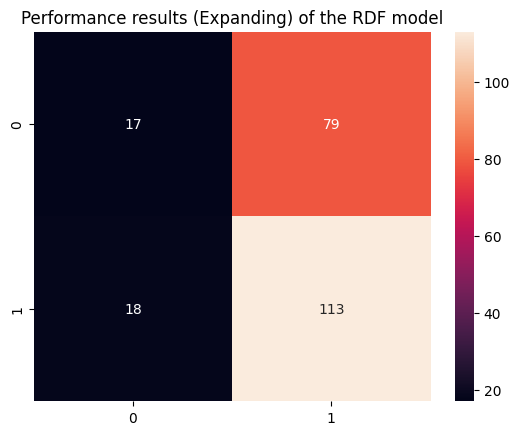


Feature Importance of the model



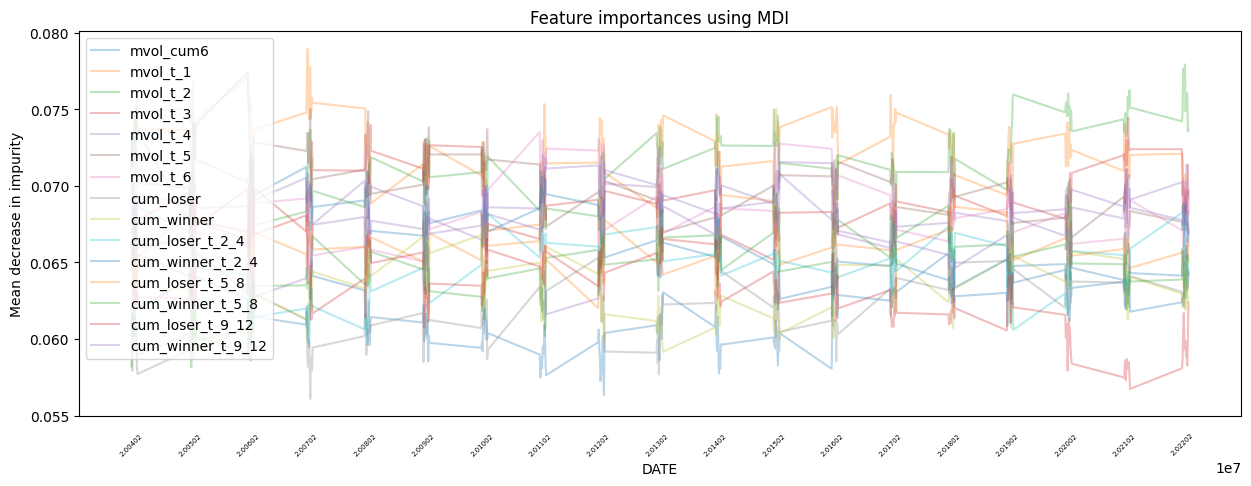

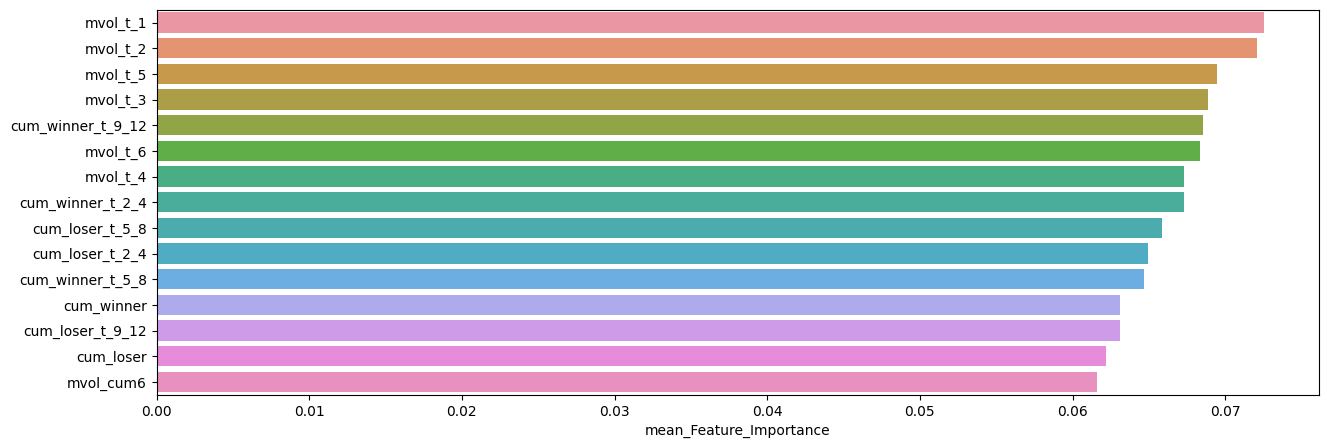

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
mvol_t_1,0.072527,0.078958,0.067083
mvol_t_2,0.072096,0.077946,0.067116
mvol_t_5,0.069459,0.075032,0.065631
mvol_t_3,0.068897,0.074472,0.063837
cum_winner_t_9_12,0.068532,0.072779,0.063211
mvol_t_6,0.068338,0.073536,0.062576
mvol_t_4,0.067314,0.071564,0.061616
cum_winner_t_2_4,0.067303,0.077469,0.061918
cum_loser_t_5_8,0.065846,0.070026,0.061658
cum_loser_t_2_4,0.064961,0.069785,0.059629


In [77]:
slice_data(Expanding_RDF_Result, 4, 'Expanding', 'RDF')